# Canny Edge Detection
- John Canny
- Steps
  - Convert to gray scale
  - Compute the gradient

- Brightness of each pixel corresponds to the strength of the gradient at that point.

- Find edges by tracing out the pixels that follow the strongest gradients.

- Image gradient
  - How fast pixel values are changing at each point in an image
  - Which direction they are changing most rapidly

- `edges_output = cv2.Canny(gray_input, low_threshold, high_threshold)`
  - Detect strong edges (strong gradient) pixels above the `high_threshold`
  - Reject pixels below the `low_threshold`
  - Pixels with values between the `low_theshold` and `high_threshold` will be included as long as they are connected to strong edges.
  - Output
    - White pixels tracing out the detected edges
    - Black pixels everywhere else
  - Thresholds
    - Gray image: 8-bit, value range: `[0, 2^8-1] = [0, 255]`
    - Possible value differences from pixel to pixel: on the scale of tens or hundreds
    - Threshold range should match this scale
    - Ratio of `low_threshold` to `high_threshold`: `1:2` or `1:3`

- Gaussian smoothing
  - Applied before `Canny`
  - Suppress noise and spurious gradients by averaging
  - `cv2.Canny` applies Gaussian smoothing internally
  - `kernel_size`
    - Area to be smoothed
    - Any odd number

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import os
import sys
module_path = os.path.abspath(os.path.join('../utility'))
if module_path not in sys.path:
    sys.path.append(module_path)
import image_helper

Original


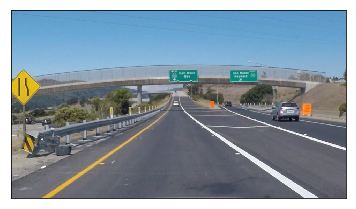

Gray image


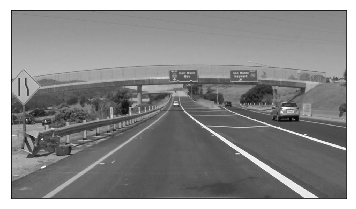

After Gaussian Blur


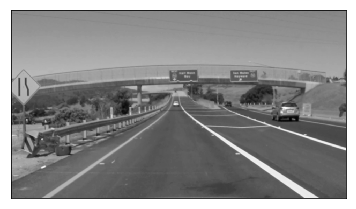

Canny Edge Detection


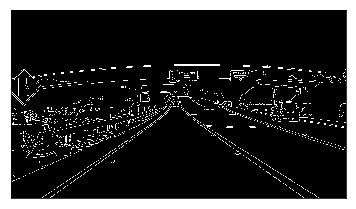

In [2]:
# Read in the image
image = mpimg.imread('input/exit-ramp.jpg')
print('Original')
plt.imshow(image)
image_helper.show()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print('Gray image')
plt.imshow(gray, cmap='gray')
image_helper.save('output/canny-edge-gray.png')
image_helper.show()

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

print('After Gaussian Blur')
plt.imshow(blur_gray, cmap='gray')
image_helper.save('output/canny-edge-gaussian-blur.png')
image_helper.show()

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
print('Canny Edge Detection')
plt.imshow(edges, cmap='Greys_r')
image_helper.save('output/canny-edge-canny.png')
image_helper.show()

# Hough Transform
- Hough space
  - Paul Hough
  - Represent `x` vs `y` lines (`y = mx + b`) as point `(m, b)` in `m` vs `b` space
    - Parallel lines have same `m`
  - A single point `(x, y)` corresponds to line `b = y - xm` in Hough space
    - Two points in image space corresponds to two **intersecting** lines in Hough space
    - The intersect point represents the line determined by the two points in image space

- Finding lines in image space is equivalent to detecting intersecting lines in Hough space
  - Divide Hough space into grid
  - Define intersecting lines as all lines passing through a given grid cell

- `m` is undefined when the line is vertical.
  - Use Polar coordinate system instead
  - `ρ = x cos θ + y sin θ`
    - `ρ` (rho): distance from origin to the line
    - `θ` (theta): angle from origin to the line (`[-90°, 90°]`)
  - Points are represented by `sine` curves in Hough space
  - Reference: [Understanding Hough Transform](https://alyssaq.github.io/2014/understanding-hough-transform/)

```python
lines = cv2.HoughLinesP(
    edges,
    rho,
    theta,
    threshold,
    np.array([]),
    min_line_len,
    max_line_gap
)
```

- `rho` and `theta`: distance and angular resolution of grid in Hough space
- `threshold`: minimum number of votes (intersections in a given grid cell) a candidate line needs to have to make it into the output
- `np.array([])`: empty array as placeholder
- `min_line_len`: minimum length of a line in pixels
- `max_line_gap`: maximum distance in pixels between segments that is allowed to be connected into a single line

Image shape: (540, 960, 3)

Region mask


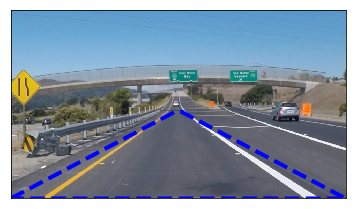

Hough transform


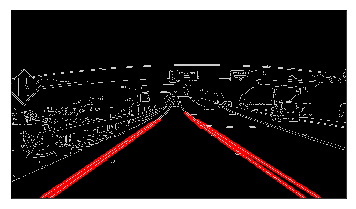

In [3]:
# Read in and grayscale the image
image = mpimg.imread('input/exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
height = imshape[0]
width = imshape[1]
lower_left = (0, height)
upper_left = (width * 0.49, height * 0.54)
upper_right = (width * 0.51, height * 0.54)
lower_right = (width, height)
vertices = np.array([[lower_left, upper_left, upper_right, lower_right]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

print("Image shape: {}".format(image.shape))
print()

# Display masked region
line_x = [lower_left[0], upper_left[0], upper_right[0], lower_right[0], lower_left[0]]
line_y = [lower_left[1], upper_left[1], upper_right[1], lower_right[1], lower_left[1]]
plt.plot(line_x, line_y, 'b--', lw=4)
plt.imshow(image)
image_helper.save('output/hough-transform-masked-region.png')
print('Region mask')
image_helper.show()

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2              # distance resolution in pixels of the Hough grid
theta = np.pi/180    # angular resolution in radians of the Hough grid
threshold = 15       # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 # minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges))

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)
image_helper.save('output/hough-transform-edge-detection.png')
print('Hough transform')
image_helper.show()